In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from frvrs_utils import FRVRSUtilities
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
import re

nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
fu = FRVRSUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)


# Recompute Poster Visualizations

In [3]:

# Get all CSVs out of one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (829277, 114)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 114)



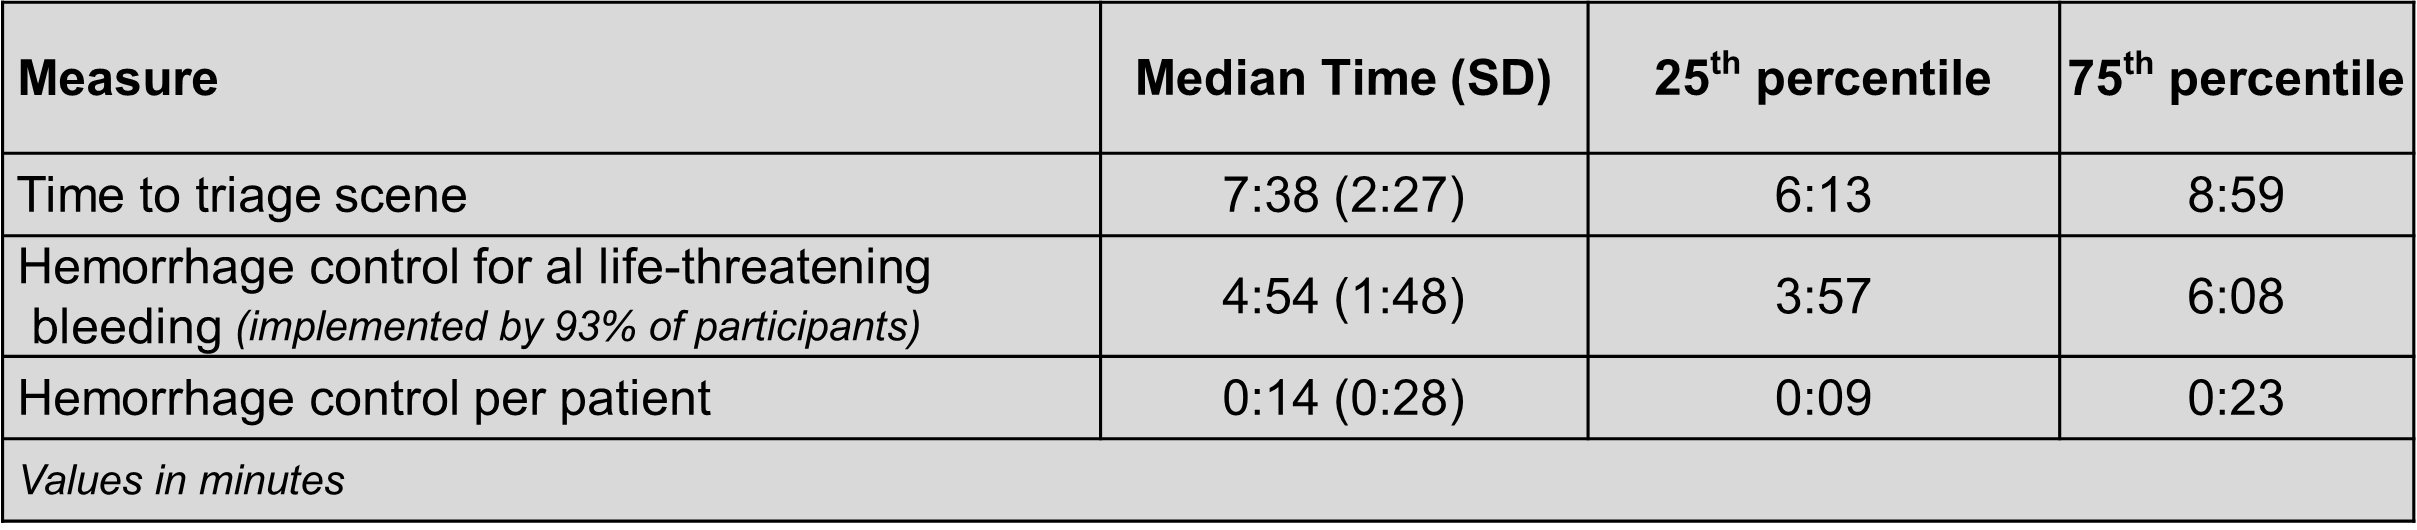

In [4]:

base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)

In [5]:

# Filter for patients with one PATIENT_ENGAGEMENT for each scene
keys_list = list(frvrs_logs_df[base_mask_series].groupby(fu.patient_groupby_columns).filter(
    lambda patient_df: fu.get_patient_engagement_count(patient_df) == 1
).groupby(fu.scene_groupby_columns).groups.keys())
f = lambda srs: (srs.session_uuid, srs.scene_index) in keys_list
keys_mask_series = frvrs_logs_df.apply(f, axis='columns')

In [6]:

# Get info for Time to triage scene row
cn = 'triage_time'
df = pd.Series(
    [fu.get_triage_time(scene_df) for _, scene_df in frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns)]
).to_frame().rename(columns={0: cn})
ttts_dict = fu.get_statistics(df, [cn]).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore').to_dict()[cn]
ttts_dict # {'mean': '7:36', 'mode': '10:22', 'median': '7:38', 'SD': '2:27', 'min': '11 sec', '25%': '6:13', '50%': '7:38', '75%': '8:59', 'max': '15:52'}

{'mean': '7:45', 'mode': '10:22', 'median': '7:41', 'SD': '2:15', 'min': '0:56', '25%': '6:20', '50%': '7:41', '75%': '9:04', 'max': '15:52'}

In [7]:

# Get info for Hemorrhage control for all life-threatening bleeding note
percent_hemorrhage_controlled = 100 * len(frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns).groups) / len(frvrs_logs_df[base_mask_series].groupby(fu.scene_groupby_columns).groups)
percent_hemorrhage_controlled # 59.430386337602826

97.68637532133675

In [8]:

# Get info for Hemorrhage control for all life-threatening bleeding row
cn = 'last_controlled_time'
df = pd.Series(
    [fu.get_time_to_last_hemorrhage_controlled(scene_df, verbose=False) for _, scene_df in frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns)]
).to_frame().rename(columns={0: cn})
hcfaltb_dict = fu.get_statistics(df, [cn]).applymap(
    lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore'
).to_dict()[cn]
hcfaltb_dict # {'mean': '5:09', 'mode': '0 sec', 'median': '4:57', 'SD': '2:02', 'min': '0 sec', '25%': '3:59', '50%': '4:57', '75%': '6:19', 'max': '15:14'}

{'mean': '5:09', 'mode': '0:00', 'median': '4:57', 'SD': '2:02', 'min': '0:00', '25%': '3:59', '50%': '4:57', '75%': '6:19', 'max': '15:14'}

In [9]:

# Get info for Hemorrhage control per patient
cn = 'controlled_time'
times_list = []
for _, scene_df in frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns):
    # scene_start = fu.get_scene_start(scene_df)
    for _, patient_df in scene_df.groupby('patient_id').filter(
        lambda patient_df: fu.get_patient_engagement_count(patient_df) == 1
    ).groupby('patient_id'):
        if fu.is_patient_hemorrhaging(patient_df):
            controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=None)
            times_list.append(controlled_time)
df = pd.Series(times_list).to_frame().rename(columns={0: cn})
hcpp_dict = fu.get_statistics(df, [cn]).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore').to_dict()[cn]
hcpp_dict # {'mean': '11 sec', 'mode': '0 sec', 'median': '8 sec', 'SD': '16 sec', 'min': '0 sec', '25%': '0 sec', '50%': '8 sec', '75%': '14 sec', 'max': '4:47'}

{'mean': '0:11', 'mode': '0:00', 'median': '0:08', 'SD': '0:16', 'min': '0:00', '25%': '0:00', '50%': '0:08', '75%': '0:14', 'max': '4:47'}

In [10]:

from IPython.display import HTML

# Define a custom CSS class for the table
table_style = """
.custom-table {
    text-decoration: none;
    font-style: normal;
    color: black;
    white-space: normal;
}

.custom-table th {
    font-weight: 700;
    border: 1.5pt solid black;
    text-align: center;
    background: #D9D9D9;
    font-size: 24.0pt;
    font-family: Arial;
    vertical-align: middle;
}

.custom-table td {
    border: 1.5pt solid black;
    text-align: left;
    padding-right: 1px;
    padding-left: 1px;
    padding-top: 1px;
    background: #D9D9D9;
    font-size: 24.0pt;
    font-family: Arial;
}

.custom-table .italic-font {
    font-style: italic;
    font-size: 20.0pt;
}

.custom-table .colspan {
    colspan: 4;
}
"""

# Apply the custom CSS class to the table
html_str = f'''
<style>
{table_style}
</style>
<table class="custom-table">
    <tr height=48 style="border:'1.5pt solid black';height:36.0pt;">
        <th height=48 style="text-align:center;">Measure</th>
        <th style="text-align:center;">Median Time (SD)</th>
        <th style="text-align:center;">25<sup>th</sup> percentile</th>
        <th style="text-align:center;">75<sup>th</sup> percentile</th>
    </tr>
    <tr height=42 style="border-top:none;border:'1.5pt solid black';height:31.2pt;">
        <td height=42 style="text-align:left;">Time to triage scene</td>
        <td style="text-align:center;border-left:none;">{ttts_dict['median']} ({ttts_dict['SD']})</td>
        <td style="text-align:center;border-left:none;">{ttts_dict['25%']}</td>
        <td style="text-align:center;border-left:none;">{ttts_dict['75%']}</td>
    </tr>
    <tr height=42 style="border-bottom:none;border-top:'1.5pt solid black';border-right:'1.5pt solid black';border-top:none;height:31.2pt;">
        <td
            height=42 style="text-align:left;"
        >Hemorrhage control for all life-threatening bleeding<br /><span class="italic-font">(implemented by {percent_hemorrhage_controlled:.01f}% of participants)</span></td>
        <td style="text-align:center;border-bottom:'1.5pt solid black';">{hcfaltb_dict['median']} ({hcfaltb_dict['SD']})</td>
        <td style="text-align:center;border-bottom:'1.5pt solid black';">{hcfaltb_dict['25%']}</td>
        <td style="text-align:center;border-bottom:'1.5pt solid black';">{hcfaltb_dict['75%']}</td>
    </tr>
    <tr height=42 style="border-top:none;height:31.2pt;">
        <td height=42 style="text-align:left;">Hemorrhage control per patient</td>
        <td style="text-align:center;border-left:none;">{hcpp_dict['median']} ({hcpp_dict['SD']})</td>
        <td style="text-align:center;border-left:none;">{hcpp_dict['25%']}</td>
        <td style="text-align:center;border-left:none;">{hcpp_dict['75%']}</td>
    </tr>
    <tr height=42>
        <td
            colspan=4 height=42 style="border-bottom:'1.5pt solid black';border-top:'1.5pt solid black';border-right:'1.5pt solid black';height:31.2pt;text-align:left;border-left:'1.5pt solid black';"
        ><span class="italic-font">Values in minutes</span></td>
    </tr>
</table>'''
with open('../saves/html/sdmph_poster_measures_table.html', 'w') as f: f.write(html_str)
HTML(html_str)


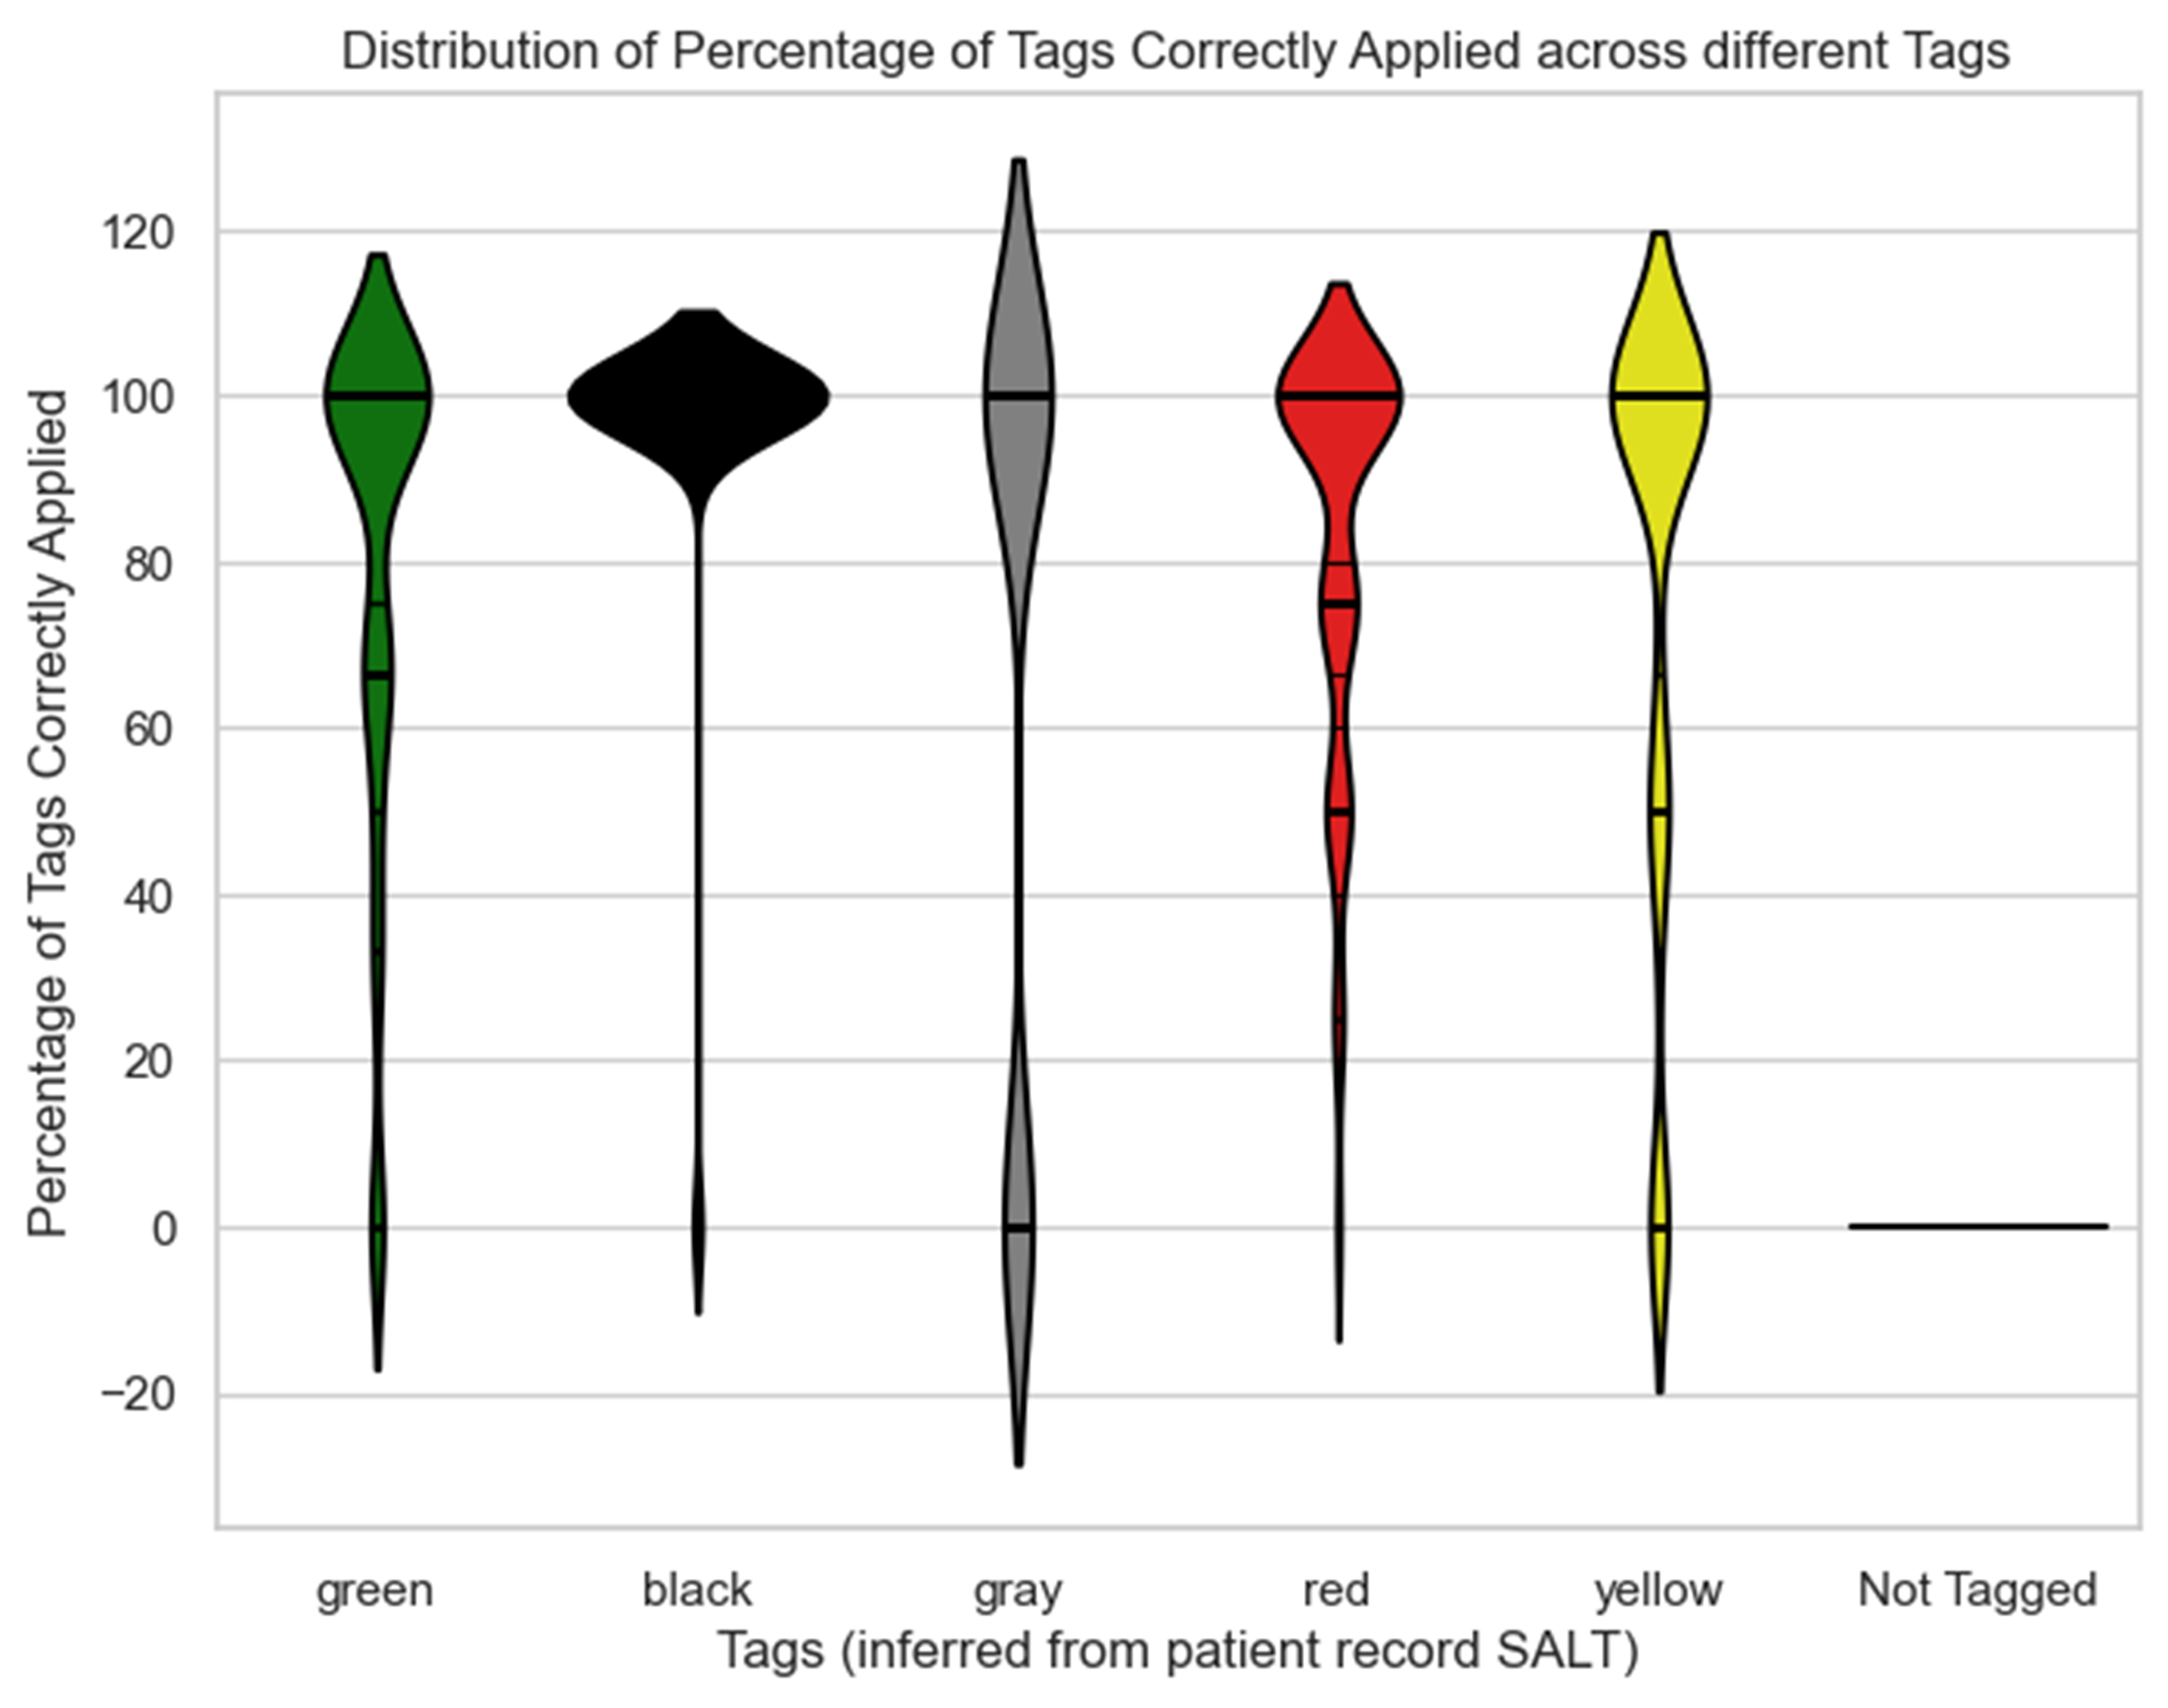

In [5]:

# Iterate through each patient of each run of each session
rows_list = []
for (session_uuid, scene_index, patient_id), patient_df in frvrs_logs_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns):
    
    # Add the logger version, groupby columns, and other run characteristics to the row dictionary
    row_dict = {}
    for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(patient_df)
    row_dict['scene_type'] = fu.get_scene_type(patient_df)
    row_dict['is_a_one_triage_file'] = fu.get_is_a_one_triage_file(patient_df)
    row_dict['patient_count'] = 1

    # Get non-null tag applied types and patient record SALTs
    mask_series = ~patient_df.tag_applied_type.isnull() | ~patient_df.patient_record_salt.isnull()
    tags_and_salts_df = patient_df[mask_series]

    # Add the last tag value
    last_tag = fu.get_last_tag(tags_and_salts_df)
    row_dict['last_tag'] = last_tag

    # Add the max salt value
    max_salt = fu.get_max_salt(patient_df=tags_and_salts_df)
    row_dict['max_salt'] = max_salt
    
    # Add the predicted tag value
    try: predicted_tag = fu.salt_to_tag_dict.get(max_salt, np.nan)
    except Exception: predicted_tag = np.nan
    row_dict['predicted_tag'] = predicted_tag
    
    # Add if tag is correct
    row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)

    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Store the patient history data frame
tag_to_salt_df = pd.DataFrame(rows_list)

# Convert the columns to the custom categorical type
tag_to_salt_df.last_tag = tag_to_salt_df.last_tag.astype(fu.colors_category_order)
tag_to_salt_df.max_salt = tag_to_salt_df.max_salt.astype(fu.salt_category_order)
tag_to_salt_df.predicted_tag = tag_to_salt_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical orders
tag_to_salt_df = tag_to_salt_df.sort_values('predicted_tag')

# Get the total and correct counts for each run for each tag
rows_list = []
tagged_mask_series = tag_to_salt_df.last_tag.isnull() | tag_to_salt_df.max_salt.isnull()

# Add the normal section
groupby_columns = ['session_uuid', 'scene_index', 'predicted_tag']
for (session_uuid, scene_index, predicted_tag), df in tag_to_salt_df[~tagged_mask_series].groupby(groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    row_dict['predicted_tag'] = predicted_tag

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    total_count = df.patient_count.sum()
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Add the not-tagged section
for (session_uuid, scene_index), df in tag_to_salt_df[tagged_mask_series].groupby(fu.scene_groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    row_dict['predicted_tag'] = 'Not Tagged'

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    total_count = df.patient_count.sum()
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)

# Convert the columns to the custom categorical type
correct_count_by_tag_df.predicted_tag = correct_count_by_tag_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical orders
correct_count_by_tag_df = correct_count_by_tag_df.sort_values('predicted_tag')

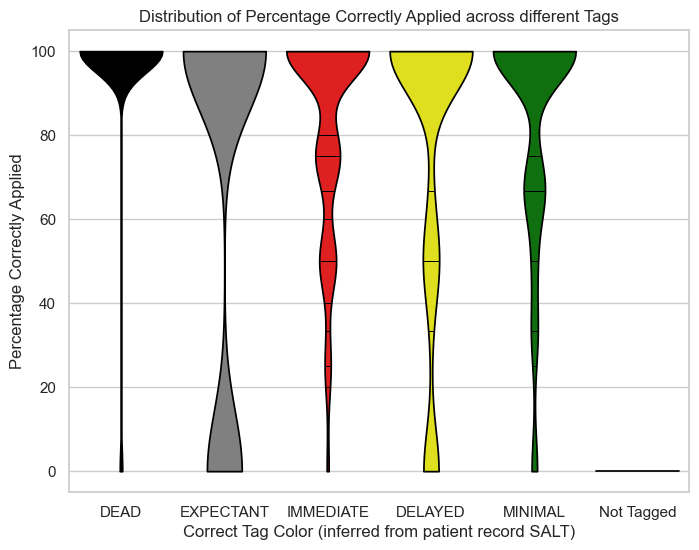

In [12]:

import seaborn as sns

# Sample data for the violin plot
data = {
    'predicted_tag': correct_count_by_tag_df.predicted_tag.tolist(),
    'percentage_tag_correct': correct_count_by_tag_df.percentage_tag_correct.tolist()
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Relabel tags as follows to match the triage error graph
df.predicted_tag = df.predicted_tag.replace({
    'black': 'DEAD',
    'gray': 'EXPECTANT',
    'green': 'MINIMAL',
    'red': 'IMMEDIATE',
    'yellow': 'DELAYED'
})

# Set the style of the plot
sns.set(style='whitegrid')

# Create the violin plot with 5 violins
plt.figure(figsize=(8, 6))
palette = ['white' if (color == 'Not Tagged') else color for color in correct_count_by_tag_df.predicted_tag.unique()]

# Make the scale from 0 to 100. This will cut off some of the violin plot
# but showing things above 100 or below 0 for a percentage does not make
# sense and will raise questions. I think it's trying to make the violin
# plot fit smoothly over values near 100 but that makes it go over 100.
# This is the same when you have ceiling effects for error bars.
sns.violinplot(x='predicted_tag', y='percentage_tag_correct', data=df, palette=palette, inner='stick', cut=0.0)

# Set plot labels and title
plt.xlabel('Correct Tag Color (inferred from patient record SALT)')
plt.ylabel('Percentage Correctly Applied')
plt.title('Distribution of Percentage Correctly Applied across different Tags')
# plt.ylim(0, 100)

# Show the plot
plt.show()


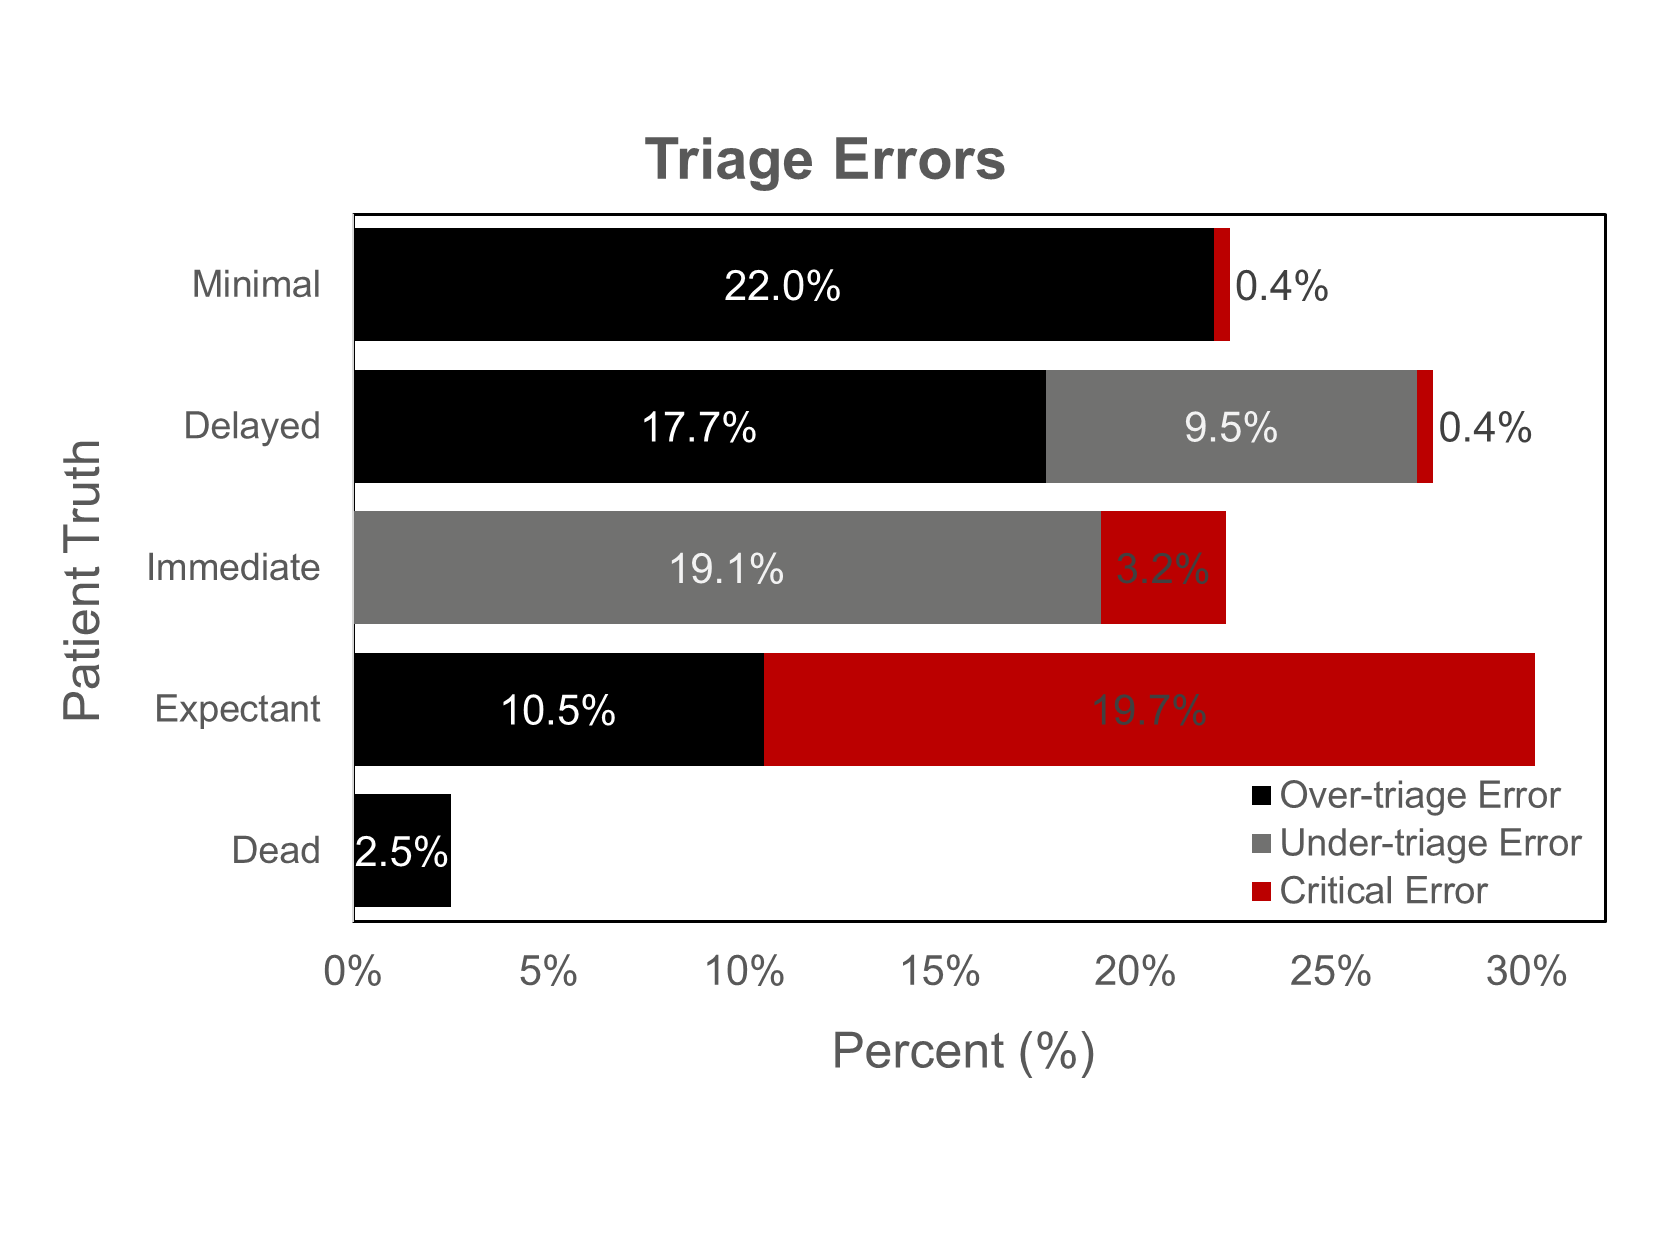

In [6]:

mask_series = (tag_to_salt_df.scene_type == 'Triage') & (tag_to_salt_df.is_scene_aborted == False) & (tag_to_salt_df.is_a_one_triage_file == True)
# mask_series &= (tag_to_salt_df.last_tag != 'Not Tagged') & ~tag_to_salt_df.last_tag.isnull() & ~tag_to_salt_df.max_salt.isnull()
groupby_columns = ['last_tag', 'max_salt']
ERROR_TYPE_DF = tag_to_salt_df[mask_series].groupby(groupby_columns).patient_count.sum().to_frame()
ERROR_TYPE_DF = ERROR_TYPE_DF.reset_index()

# Remove "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF.apply(f, axis='columns')

# Convert the columns to the custom categorical type
ERROR_TYPE_DF['last_tag'] = ERROR_TYPE_DF['last_tag'].astype(fu.colors_category_order)
ERROR_TYPE_DF['max_salt'] = ERROR_TYPE_DF['max_salt'].astype(fu.salt_category_order)
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
ERROR_TYPE_DF = ERROR_TYPE_DF.sort_values(by=groupby_columns+['error_type'])

In [7]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)

In [46]:

def show_stacked_horizontal_bar_chart(column_name, ylabel=''):
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    over_values, under_values, critical_values = [], [], []
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').patient_count.sum().reset_index()
        total_patient_count = df.patient_count.sum()
        error_dict = df.set_index('error_type').patient_count.to_dict()
        
        over_patient_count = error_dict.get('Over', 0)
        over_values.append(100*over_patient_count/total_patient_count)
        
        under_patient_count = error_dict.get('Under', 0)
        under_values.append(100*under_patient_count/total_patient_count)
        
        critical_patient_count = error_dict.get('Critical', 0)
        critical_values.append(100*critical_patient_count/total_patient_count)
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(unique_categories, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(unique_categories, under_values, color='#717170', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    critical_bar = plt.barh(
        unique_categories, critical_values, color='#bb0000', label=suffixing_fn('Critical'), left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (bar.get_facecolor() == (0.7333333333333333, 0.0, 0.0, 1.0)):
                if (value >= 2.0): plt.text(
                    bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='#404040'
                )
                elif (value > 0): plt.text(
                    bar.get_x() + bar.get_width() + 1.2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='black'
                )
            else:
                if (value >= 2.0): plt.text(
                    bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
                )
                elif (value > 0): plt.text(
                    bar.get_x() + bar.get_width() + 1.2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='black'
                )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(False)
    
    # Display the chart
    plt.show()

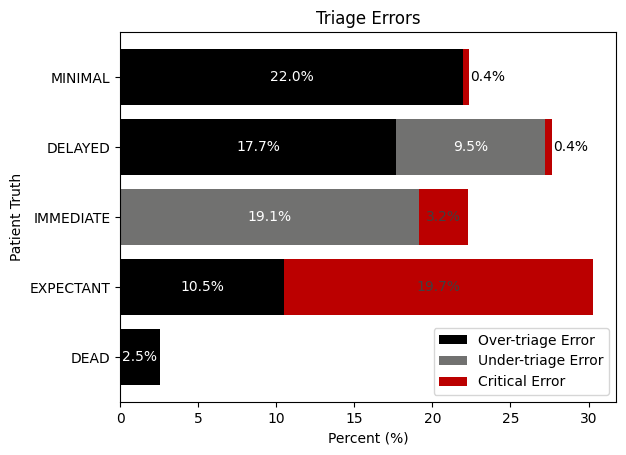

In [47]:

show_stacked_horizontal_bar_chart('max_salt', ylabel='Patient Truth')


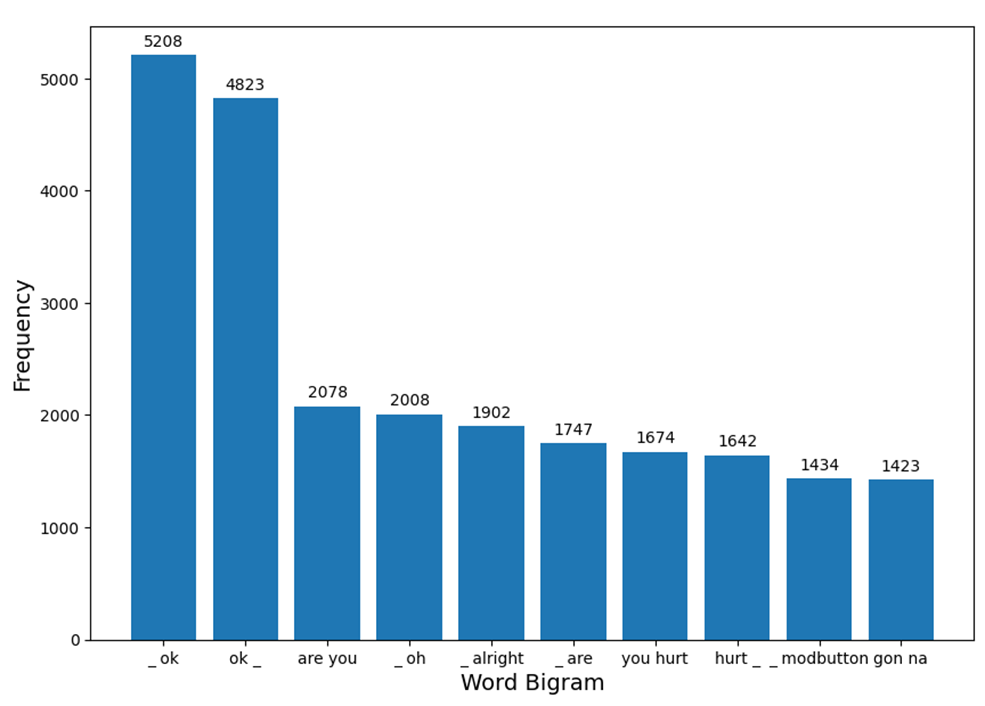

In [17]:

def ultimate_tokenize(sentence):
    
    # Remove punctuation and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    return word_tokenize(sentence.lower())

In [18]:

import string
from nltk import ngrams, FreqDist, word_tokenize

mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
df = frvrs_logs_df[mask_series]
voice_capture_tokens_words = [ultimate_tokenize(x) for x in df.voice_capture_message]
voice_capture_tokens_words_trigrams = [
    list(
        ngrams(x, 3, pad_left=False, pad_right=False, left_pad_symbol='_', right_pad_symbol='_')
    ) for x in voice_capture_tokens_words
]
for x in voice_capture_tokens_words_trigrams[0]:
    print(x)

('set', 'lay', 'down')


In [19]:

trigram_freqdists_list = [FreqDist(x) for x in voice_capture_tokens_words_trigrams]
for freqdist_obj in trigram_freqdists_list:
    freqdist_obj.pprint()
    break

FreqDist({('set', 'lay', 'down'): 1})


In [20]:

trigram_dict = dict()
for freqdist_obj in trigram_freqdists_list:
    for k, v in freqdist_obj.items():
        k = ' '.join(k)
        if k in trigram_dict: v += trigram_dict[k]
        trigram_dict[k] = v

# Display a sub-dictionary with a number of random keys and their values
nu.get_random_subdictionary(trigram_dict)

{'hands oh we': 1, 'a delayed patient': 1, 'poles and we': 1, 'guy over here': 14, 'is it only': 1}

In [21]:

import operator

trigram_freqs = sorted(trigram_dict.items(), key=operator.itemgetter(1), reverse=True)
trigram_freqs[:10]

[('are you hurt', 1628), ('if you can', 583), ('im gon na', 575), ('you can hear', 402), ('modbutton im okay', 374), ('can you hear', 371), ('there we go', 348), ('can hear me', 318), ('you hear me', 280), ('were gon na', 279)]

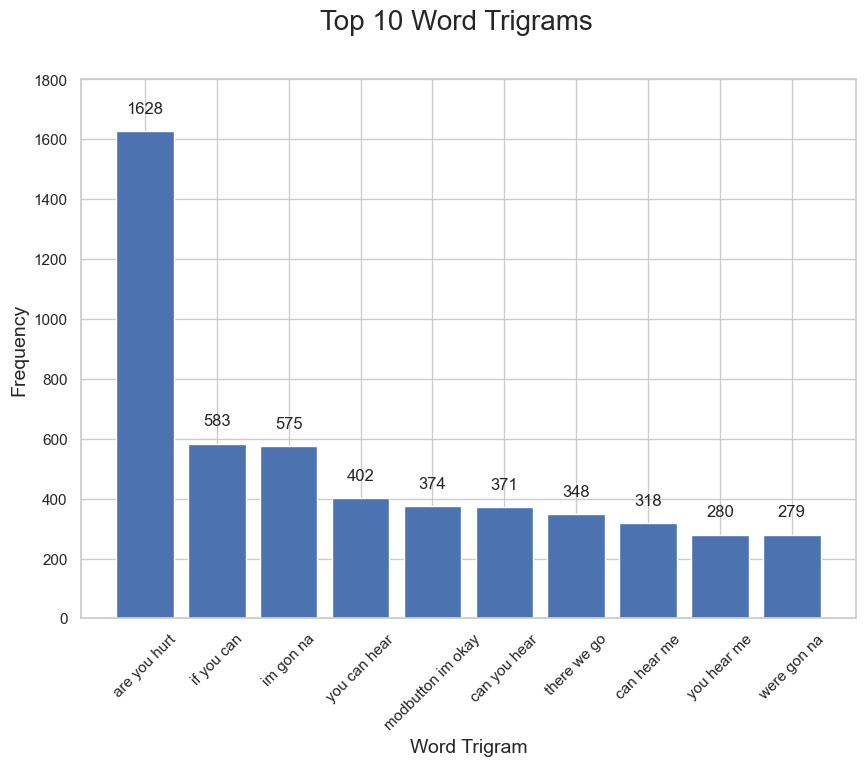

In [22]:

from numpy import arange

labels, values = zip(*trigram_freqs[:10])
indexes = arange(len(labels))
width = 0.8 # width = 1 would give bars that overlap because they are too close

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca() # Get current axis
rects = ax.bar(indexes, values, width)

# Add title and axis labels
fig.suptitle('Top 10 Word Trigrams', fontsize=20)
plt.xlabel('Word Trigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 1_800)

# Display value of each bar on bar
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 50 + height, '%d' % int(height), ha='center', va='bottom') # Can also add color and fontweight arguments.

# Remove the default x-axis tick numbers and use tick numbers of your own choosing
ax.set_xticks(indexes)

# Replace the tick numbers with strings
ax.set_xticklabels(labels, rotation=45)

plt.show()
# plt.savefig('top10EnglishWordTrigrams.png')


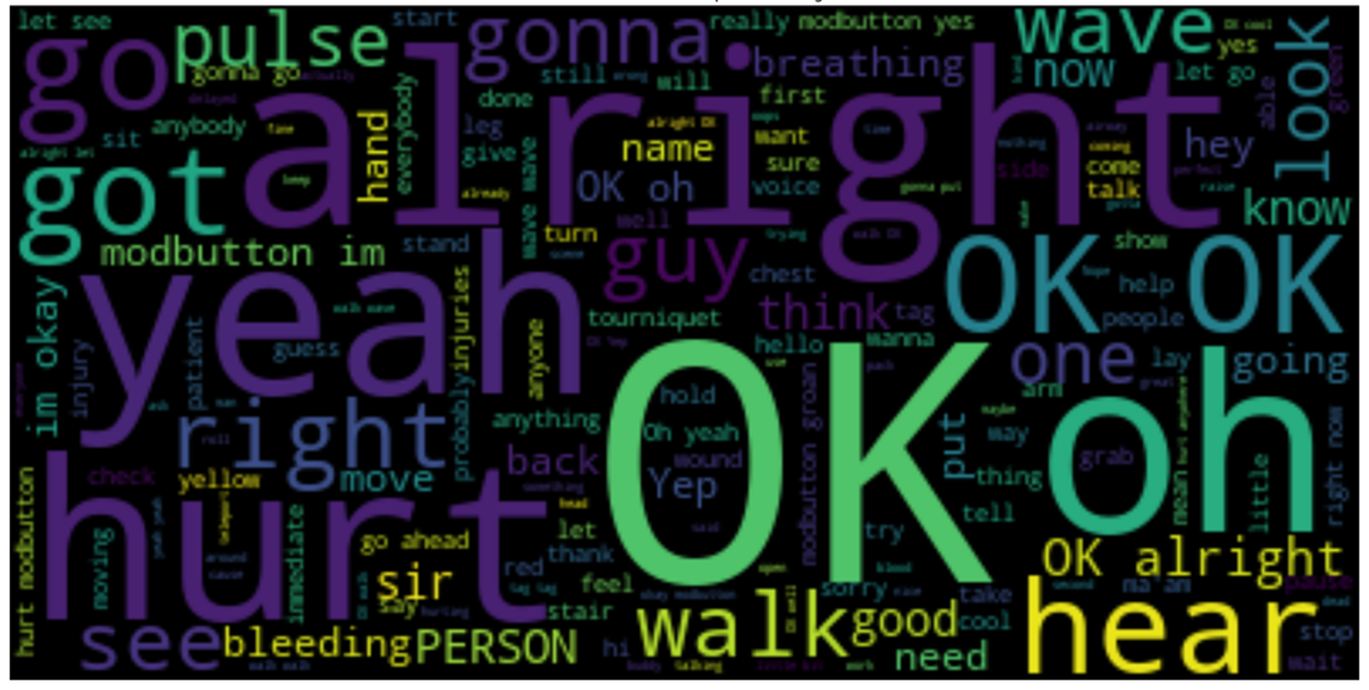

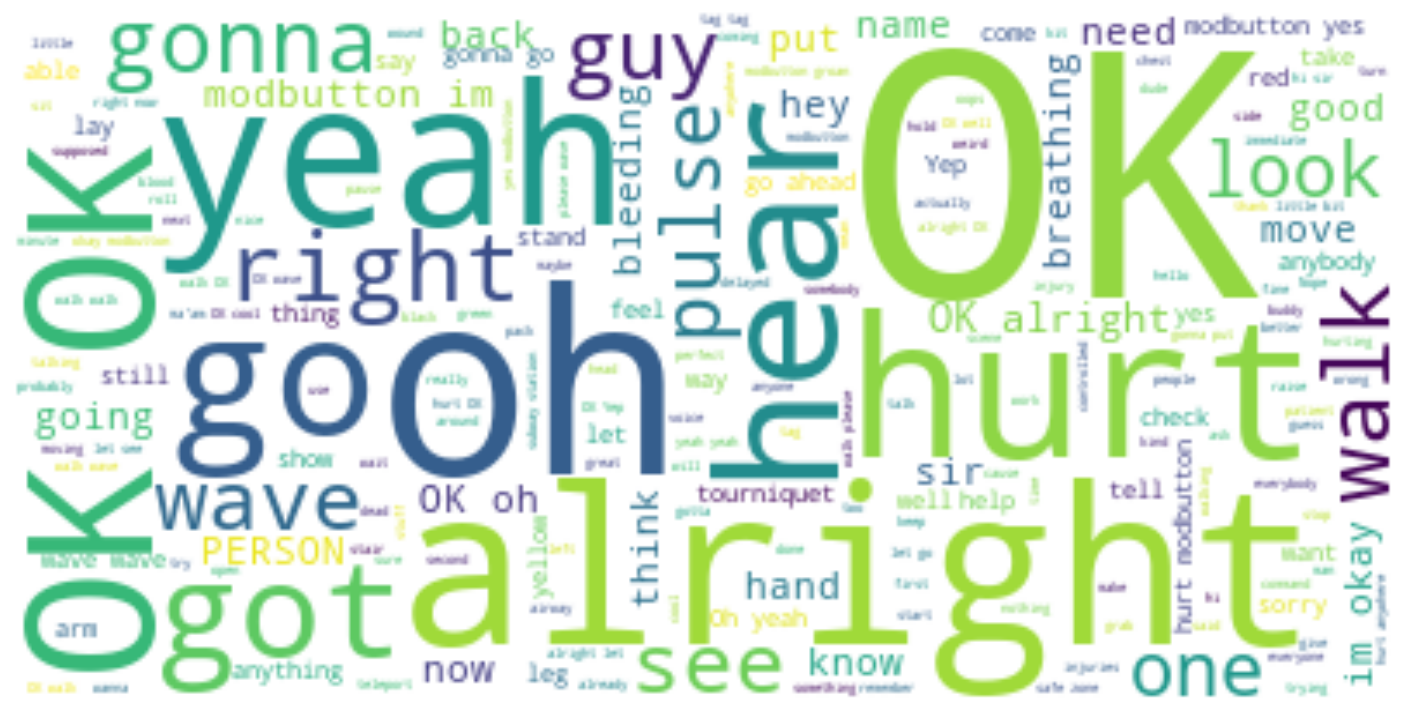

In [23]:

from wordcloud import WordCloud

# Flatten the list of lists of words
mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
voice_capture_words_list_list = frvrs_logs_df[mask_series].voice_capture_message.tolist()
voice_capture_words_list = []
for voice_capture_words in voice_capture_words_list_list: voice_capture_words_list += voice_capture_words.split()

# Create a word cloud object
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color='white').generate(' '.join(voice_capture_words_list))

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud of Voice Capture Messages')
plt.show()